<a href="https://colab.research.google.com/github/BadriAmouri/covid19-time-series-forecasting/blob/main/Individual_Project_Time_Series_Badri_Amouri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID-19 Time Series Analysis & Forecasting


This project analyzes the global spread of COVID-19 using time series techniques in R . The dataset, sourced from Johns Hopkins University (JHU), contains daily confirmed cases worldwide.


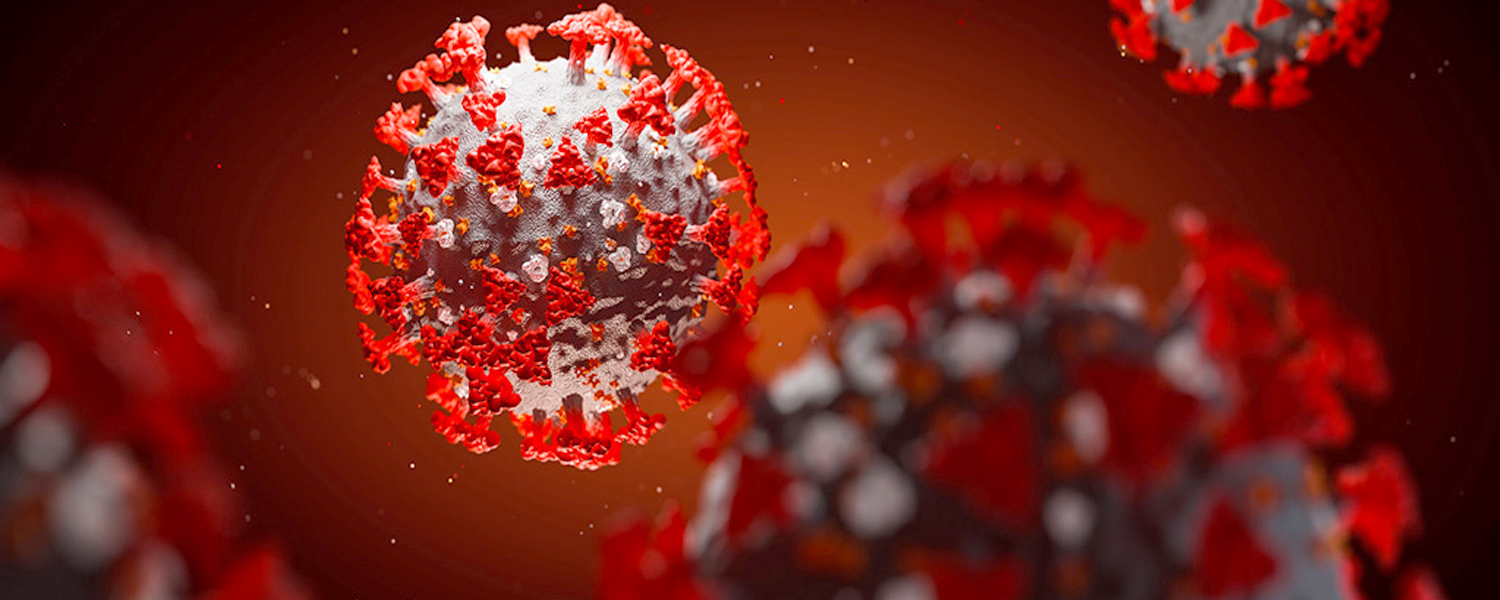

## Data Loading

Install and Load Required Libraries

In [89]:
# Install required packages (only run once)
install.packages(c("tidyverse", "lubridate", "forecast", "tseries", "ggplot2"))

# Load libraries
library(tidyverse)   # For data manipulation
library(lubridate)   # For date handling
library(forecast)    # For ARIMA modeling
library(tseries)     # For stationarity tests
library(ggplot2)     # For data visualization

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [90]:
# Load COVID-19 confirmed cases dataset
url <- "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
covid_data <- read.csv(url, check.names = FALSE)

# View the first few rows
head(covid_data)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,⋯,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,,Afghanistan,33.93911,67.70995,0,0,0,0,0,0,⋯,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451
2,,Albania,41.15330,20.16830,0,0,0,0,0,0,⋯,334391,334408,334408,334427,334427,334427,334427,334427,334443,334457
3,,Algeria,28.03390,1.65960,0,0,0,0,0,0,⋯,271441,271448,271463,271469,271469,271477,271477,271490,271494,271496
4,,Andorra,42.50630,1.52180,0,0,0,0,0,0,⋯,47866,47875,47875,47875,47875,47875,47875,47875,47890,47890
5,,Angola,-11.20270,17.87390,0,0,0,0,0,0,⋯,105255,105277,105277,105277,105277,105277,105277,105277,105288,105288
6,,Antarctica,-71.94990,23.34700,0,0,0,0,0,0,⋯,11,11,11,11,11,11,11,11,11,11


In [91]:
# Rename columns for easier access
colnames(covid_data)[1:4] <- c("Province_State", "Country_Region", "Lat", "Long")

# Convert wide format to long format
covid_long <- covid_data %>%
  pivot_longer(cols = -c(Province_State, Country_Region, Lat, Long),
               names_to = "Date",
               values_to = "Confirmed_Cases")

# Convert Date column to proper date format
covid_long$Date <- as.Date(covid_long$Date, format="%m/%d/%y")

# View the transformed dataset
head(covid_long)

Province_State,Country_Region,Lat,Long,Date,Confirmed_Cases
<chr>,<chr>,<dbl>,<dbl>,<date>,<int>
,Afghanistan,33.93911,67.70995,2020-01-22,0
,Afghanistan,33.93911,67.70995,2020-01-23,0
,Afghanistan,33.93911,67.70995,2020-01-24,0
,Afghanistan,33.93911,67.70995,2020-01-25,0
,Afghanistan,33.93911,67.70995,2020-01-26,0
,Afghanistan,33.93911,67.70995,2020-01-27,0


In [92]:
# Summarize global confirmed cases per date
global_cases <- covid_long %>%
  group_by(Date) %>%
  summarise(Total_Cases = sum(Confirmed_Cases))

# View data
head(global_cases)

Date,Total_Cases
<date>,<int>
2020-01-22,557
2020-01-23,657
2020-01-24,944
2020-01-25,1437
2020-01-26,2120
2020-01-27,2929


In [93]:
# Convert data to time series format
covid_ts <- ts(global_cases$Total_Cases,
               start = c(2020, as.numeric(format(min(global_cases$Date), "%j"))),
               frequency = 365)

# Check the structure of the time series
print(covid_ts)

Time Series:
Start = c(2020, 22) 
End = c(2023, 69) 
Frequency = 365 
   [1]       557       657       944      1437      2120      2929      5580
   [8]      6169      8237      9927     12038     16787     19887     23899
  [15]     27644     30806     34400     37131     40162     42771     44814
  [22]     45232     60384     66912     69055     71238     73273     75155
  [29]     75655     76216     76846     78608     78990     79558     80412
  [36]     81384     82728     84152     86023     88402     90382     92994
  [43]     95338     98078    102062    106199    109997    114292    119051
  [50]    126527    133283    146477    157365    168598    183165    198339
  [57]    215900    242987    272517    304944    339156    381711    423594
  [64]    475075    535889    599820    669402    725918    790929    869371
  [71]    955728   1038176   1122386   1182507   1254222   1328948   1397886
  [78]   1480062   1567243   1653665   1729180   1847761   1919593   2004226
  [85]

The sampling frequency of your COVID-19 dataset is **daily** (1 observation per day).

	•	The time series starts at day 22 of 2020 (January 22, 2020) and ends at day 69 of 2023 (March 10, 2023).
	•	The frequency is set to 365, meaning the data is recorded once per day throughout the entire period.

Split it into test and train

In [133]:
# Define split point (80% training, 20% testing)
train_size <- round(0.8 * length(covid_ts))  # 80% of data
test_size <- length(covid_ts) - train_size   # Remaining 20%

# Create train and test sets
train_ts <- covid_ts[1:train_size]  # First 80% of data
test_ts <- covid_ts[(train_size + 1):length(covid_ts)]  # Last 20% of data

# Print sizes
length(train_ts)  # Should be around 914
length(test_ts)   # Should be around 229

[1] 914

[1] 229

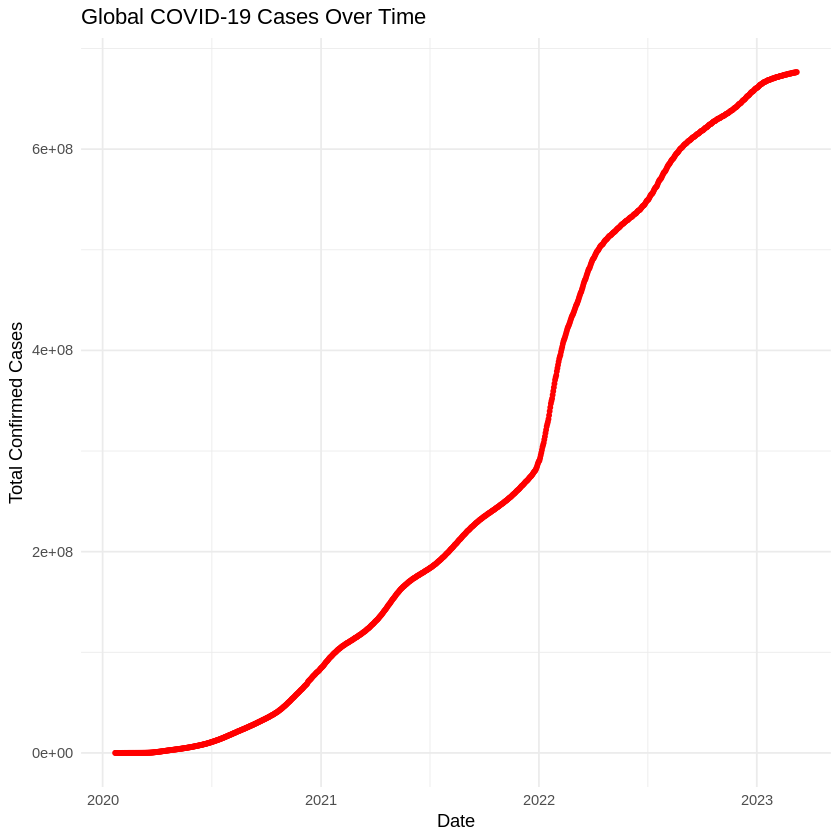

In [134]:
ggplot(global_cases, aes(x = Date, y = Total_Cases)) +
  geom_line(color = "blue", size = 1) +
  geom_point(color = "red", size = 1) +
  labs(title = "Global COVID-19 Cases Over Time",
       x = "Date",
       y = "Total Confirmed Cases") +
  theme_minimal()

##  Exploratory Data Analysis (EDA)

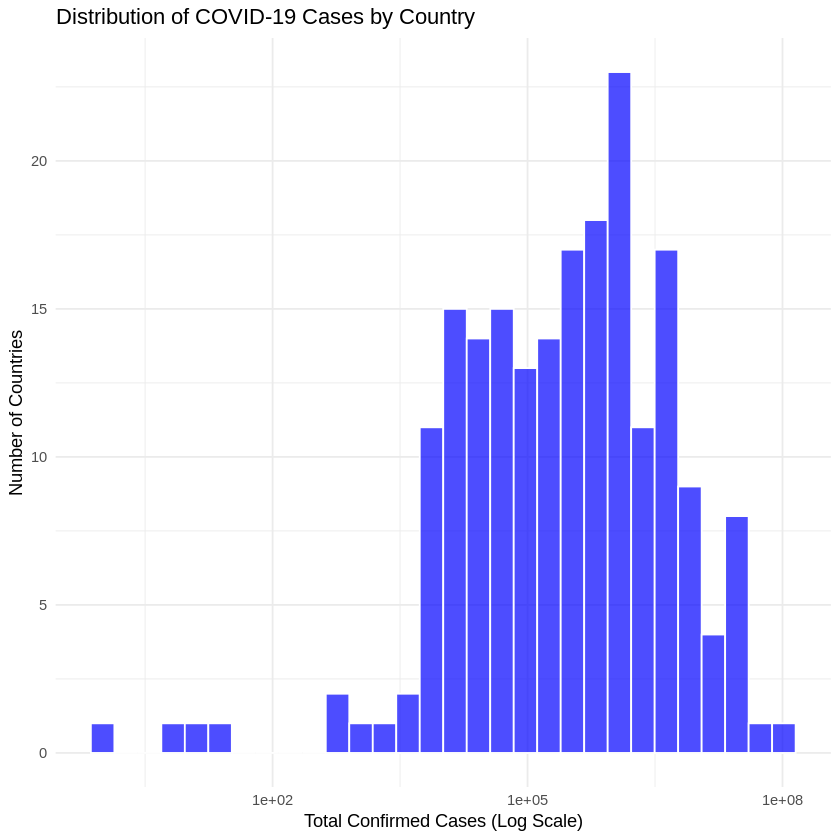

In [95]:
# Summarize total cases per country (latest available date)
latest_date <- max(covid_long$Date)
country_totals <- covid_long %>%
  filter(Date == latest_date) %>%
  group_by(Country_Region) %>%
  summarise(Total_Cases = sum(Confirmed_Cases))

# Plot histogram
ggplot(country_totals, aes(x = Total_Cases)) +
  geom_histogram(bins = 30, fill = "blue", color = "white", alpha = 0.7) +
  scale_x_log10() +  # Use log scale to handle large variations
  labs(title = "Distribution of COVID-19 Cases by Country",
       x = "Total Confirmed Cases (Log Scale)",
       y = "Number of Countries") +
  theme_minimal()

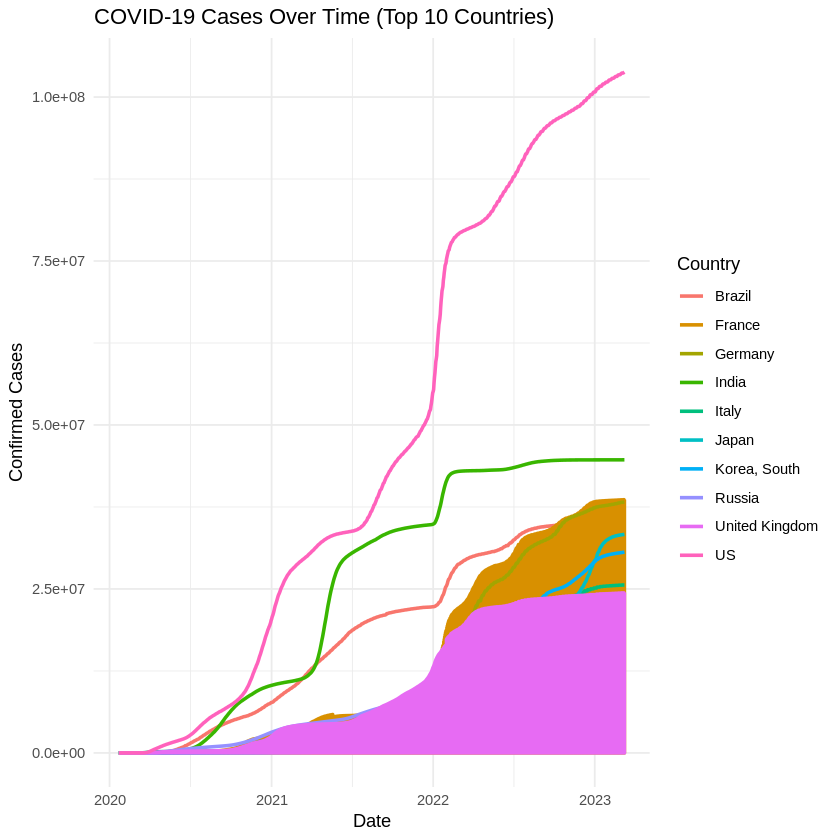

In [96]:
# Get top 10 countries with highest cases on latest date
top_countries <- country_totals %>%
  arrange(desc(Total_Cases)) %>%
  head(10) %>%
  pull(Country_Region)

# Filter data for only the top 10 countries
top_countries_data <- covid_long %>%
  filter(Country_Region %in% top_countries)

# Plot cases over time for top 10 countries
ggplot(top_countries_data, aes(x = Date, y = Confirmed_Cases, color = Country_Region)) +
  geom_line(size = 1) +
  labs(title = "COVID-19 Cases Over Time (Top 10 Countries)",
       x = "Date",
       y = "Confirmed Cases",
       color = "Country") +
  theme_minimal()

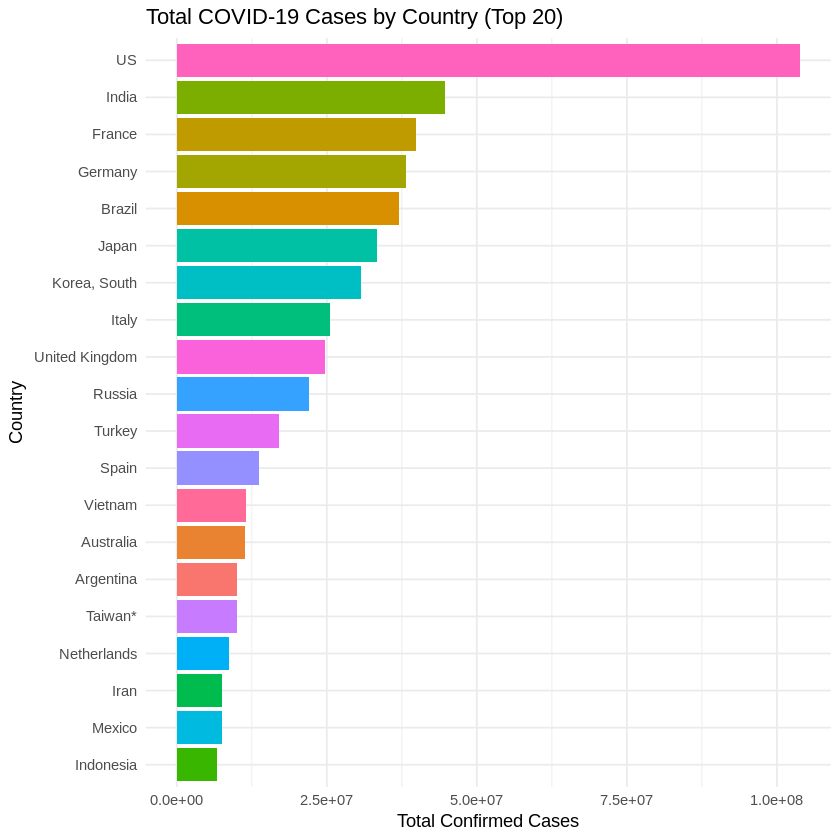

In [97]:
# Get top 20 countries with highest total cases
top_20_countries <- country_totals %>%
  arrange(desc(Total_Cases)) %>%
  head(20)

# Plot histogram (bar chart)
ggplot(top_20_countries, aes(x = reorder(Country_Region, Total_Cases), y = Total_Cases, fill = Country_Region)) +
  geom_bar(stat = "identity", show.legend = FALSE) +  # Bar chart
  coord_flip() +  # Flip for better readability
  labs(title = "Total COVID-19 Cases by Country (Top 20)",
       x = "Country",
       y = "Total Confirmed Cases") +
  theme_minimal()

The bar chart shows the total COVID-19 cases for the top 20 countries, with the USA significantly leading, followed by India, France, Germany, and Brazil. The USA has an overwhelmingly higher number of cases, making other countries appear much smaller in comparison. This suggests that focusing only on the USA and the top 4 countries could be more insightful, as the remaining 15 countries have relatively lower case counts and may not contribute much to the overall trend analysis. we may use this approach later

In [98]:
sum(is.na(covid_ts))

[1] 0

In [99]:
str(covid_data)

'data.frame':	289 obs. of  1147 variables:
 $ Province_State: chr  "" "" "" "" ...
 $ Country_Region: chr  "Afghanistan" "Albania" "Algeria" "Andorra" ...
 $ Lat           : num  33.9 41.2 28 42.5 -11.2 ...
 $ Long          : num  67.71 20.17 1.66 1.52 17.87 ...
 $ 1/22/20       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ 1/23/20       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ 1/24/20       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ 1/25/20       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ 1/26/20       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ 1/27/20       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ 1/28/20       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ 1/29/20       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ 1/30/20       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ 1/31/20       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ 2/1/20        : int  0 0 0 0 0 0 0 0 0 0 ...
 $ 2/2/20        : int  0 0 0 0 0 0 0 0 0 0 ...
 $ 2/3/20        : int  0 0 0 0 0 0 0 0 0 0 ...
 $ 2/4/20        : int  0 0 0 0 0 0 0 0 0 0 ...
 $ 2/5/20        : int  0 0 0 0 0 0 0 0 0 0 ...
 $ 2/6/20        

# Phase I: Identification

##  Check for Variance Instability

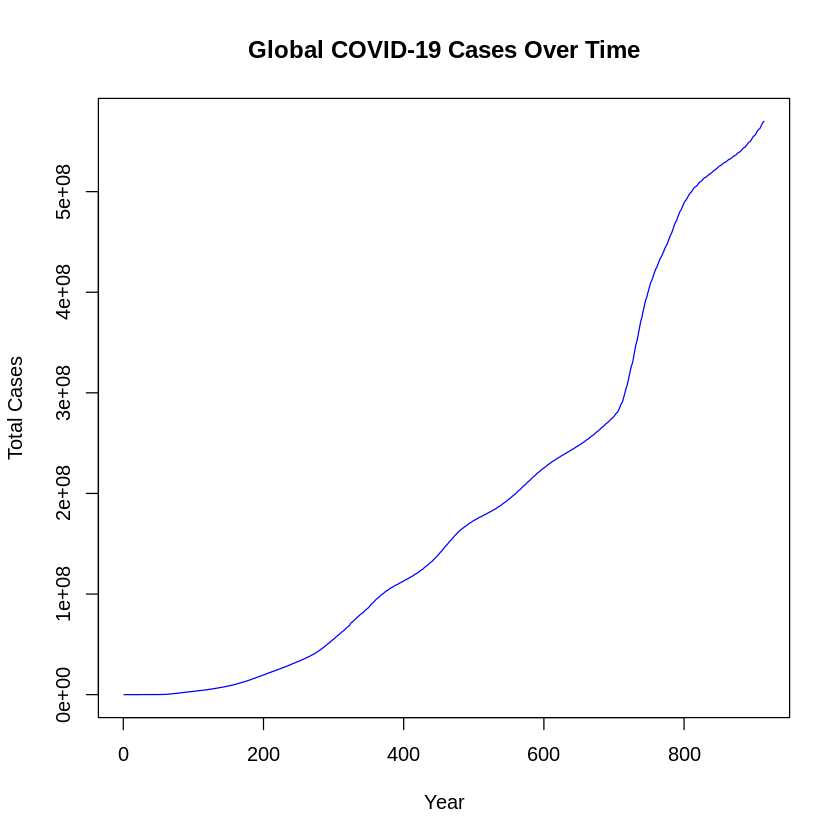

In [135]:
plot(train_ts,
     main="Global COVID-19 Cases Over Time",
     ylab="Total Cases", xlab="Year", col="blue", type="l")

The plot shows a strong upward trend over time, indicating a clear increase in the observed values :

	•	 Exponential Growth: The curve is not linear but rather follows an exponential trend—it starts slowly, then rapidly increases.
  
	•	 Increasing Variance: The gap between values expands over time, which suggests heteroscedasticity (non-constant variance).

	•	 Non-Stationarity: The trend indicates that the time series is not stationary, meaning it has a changing mean and variance.

this would suggest to do Lag-Transfomation and Differencing

To stabilize variance in your time series, the log transformation is a great choice, especially since My data follows an exponential trend.

In [136]:
log_data <- log(train_ts)

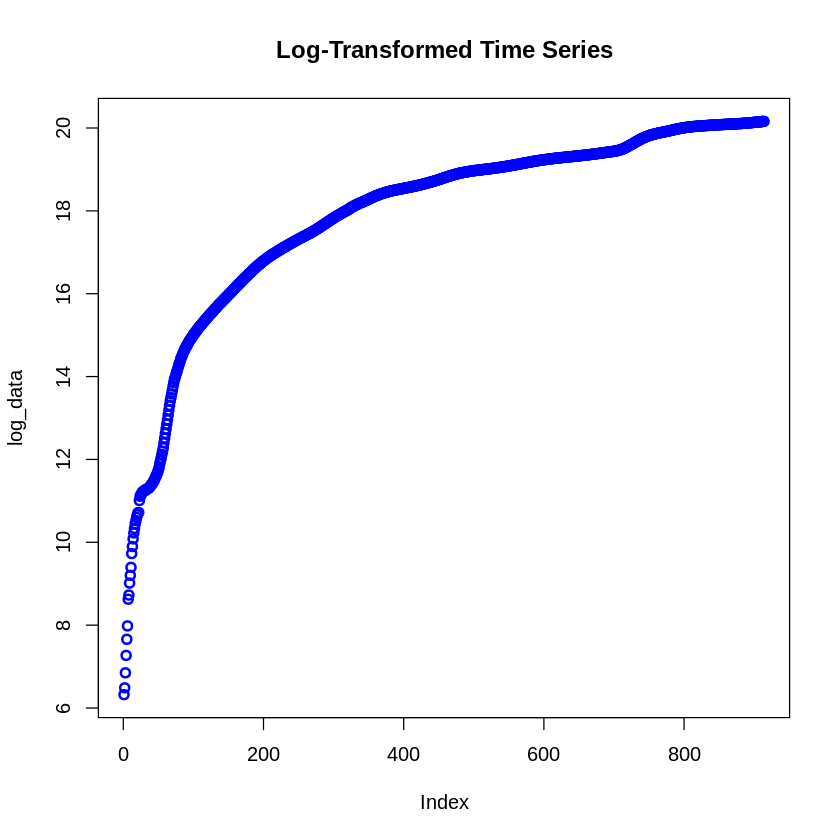

In [137]:
plot(log_data, main="Log-Transformed Time Series", col="blue", lwd=2)

to check if the log transformation handled the variance transformation we apply something called **Rolling standard deviation**   
 you calculate the rolling standard deviation and compare it before and after transformation.

 **Rolling standard deviation** :

If the rolling SD fluctuates significantly, it means the variance changes over time (heteroskedasticity).

	•	This suggests the need for transformation (e.g., log transformation).

  •	If the rolling SD becomes relatively flat, it indicates stabilized variance (homoskedasticity).
  
	•	A stable rolling SD is a key assumption for many statistical models, such as ARIMA.

Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“NAs introduced by coercion”
Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“NAs introduced by coercion”
Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“NAs introduced by coercion”
Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“NAs introduced by coercion”
Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“NAs introduced by coercion”
Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“NAs introduced by coercion”
Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“NAs introduced by coercion”
Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“NAs introduced by coercion”
Warning message 

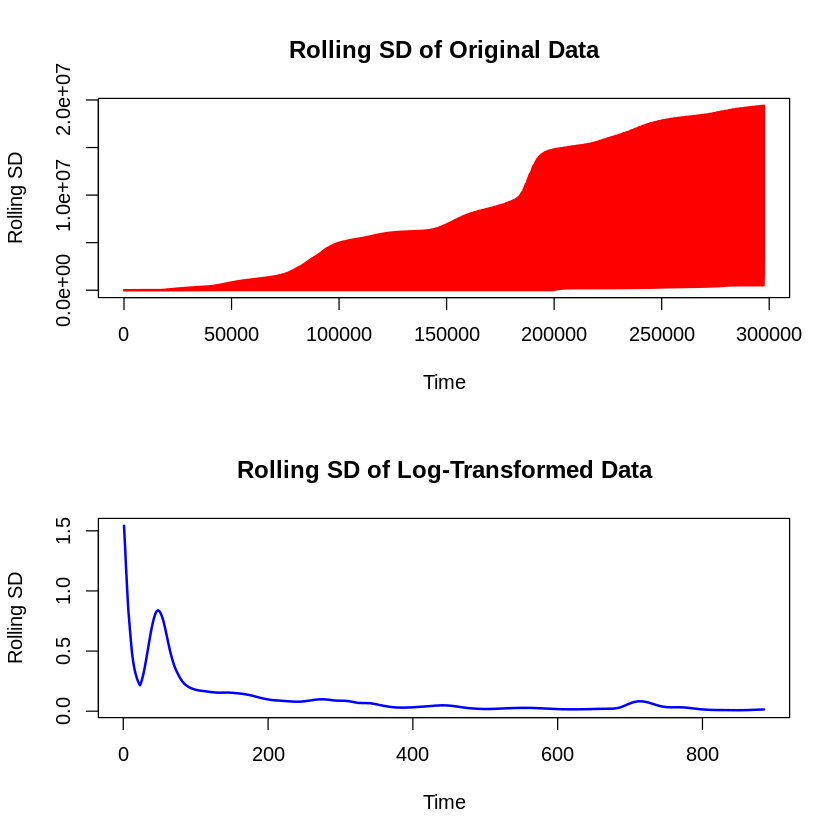

In [138]:
# Load required package
library(zoo)

# Define window size (e.g., 30 days)
window_size <- 30

# Compute rolling standard deviation
rolling_sd_original <- rollapply(covid_data, width=window_size, FUN=sd, fill=NA, align="right")
rolling_sd_log <- rollapply(log_data, width=window_size, FUN=sd, fill=NA, align="right")

# Remove leading NAs to establish finite xlim values
rolling_sd_original <- rolling_sd_original[!is.na(rolling_sd_original)]
rolling_sd_log <- rolling_sd_log[!is.na(rolling_sd_log)]

# Plot rolling standard deviations
par(mfrow=c(2,1))  # Split plot into 2 panels

plot(rolling_sd_original, type="l", col="red", main="Rolling SD of Original Data",
     ylab="Rolling SD", xlab="Time", lwd=2)
plot(rolling_sd_log, type="l", col="blue", main="Rolling SD of Log-Transformed Data",
     ylab="Rolling SD", xlab="Time", lwd=2)

par(mfrow=c(1,1))  # Reset plotting layout

	•	Top (Red Area) - Rolling SD of Original Data:
	•	The variance increases over time, indicating heteroskedasticity (changing variance).
	•	Bottom (Blue Line) - Rolling SD of Log-Transformed Data:
	•	The fluctuations are much smaller and relatively stable over time.
	•	This suggests that the log transformation successfully stabilized the variance.

 Conclusion:

The log transformation was effective in reducing variance fluctuations. Now we must check the Differencing Part

##  Differencing

Before applying differencing, we can check if the log-transformed data is stationary using the Autocorrelation Function (ACF).


	Augmented Dickey-Fuller Test

data:  log_data
Dickey-Fuller = -3.8712, Lag order = 9, p-value = 0.01544
alternative hypothesis: stationary


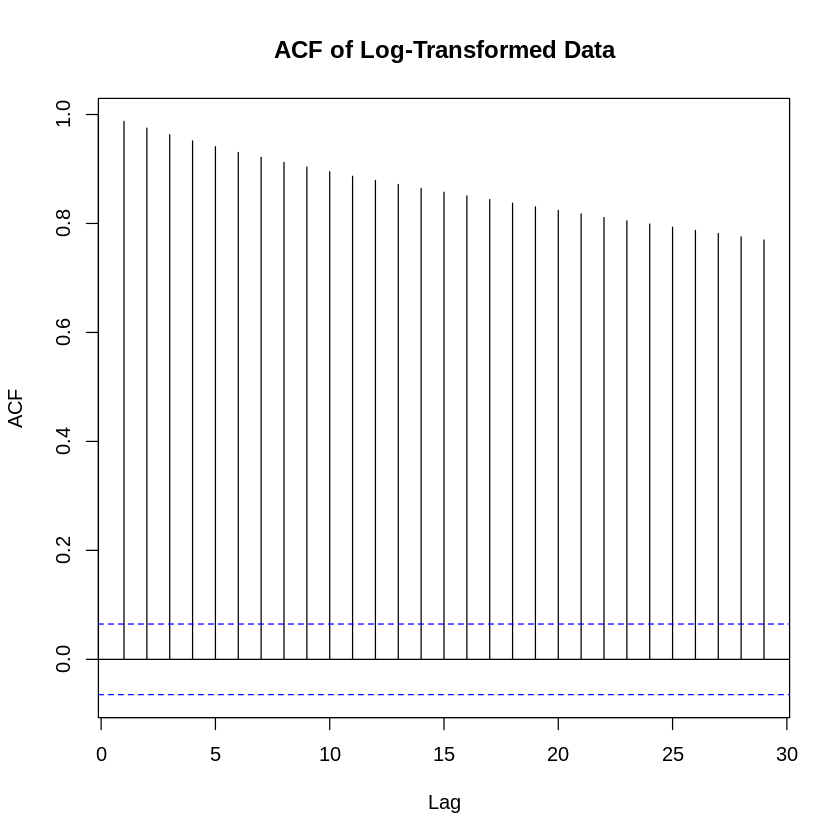

Warning message in adf.test(diff_log_data):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  diff_log_data
Dickey-Fuller = -8.3297, Lag order = 9, p-value = 0.01
alternative hypothesis: stationary


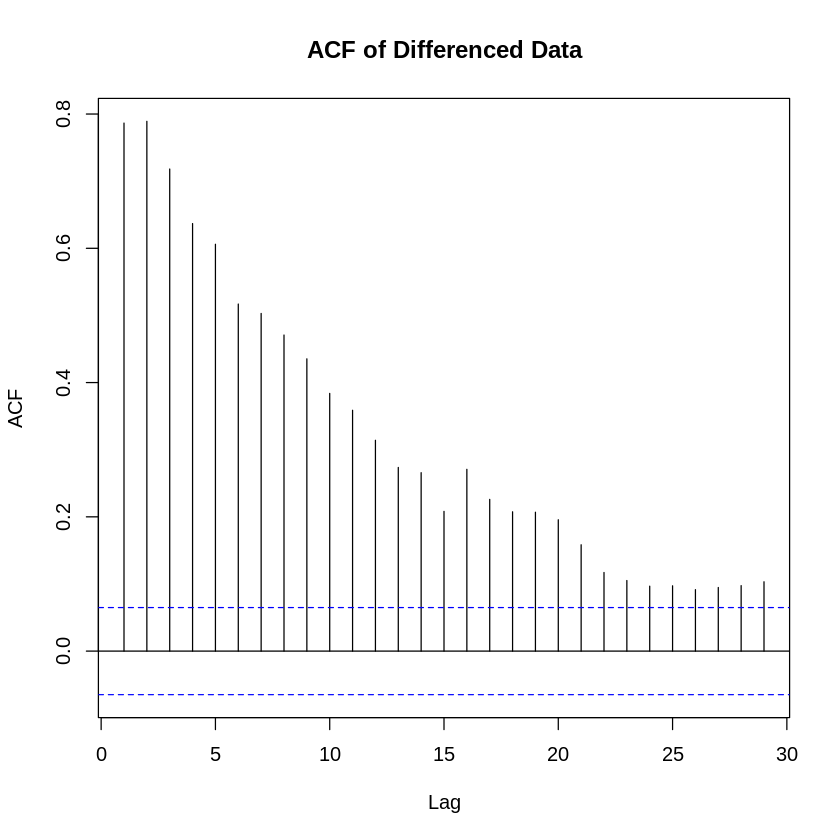

In [139]:
# Step 1: Plot ACF of log-transformed data
acf(log_data, main="ACF of Log-Transformed Data")

# Step 2: Perform Augmented Dickey-Fuller Test to check for stationarity
adf.test(log_data)

# Step 3: Apply first-order differencing if needed
diff_log_data <- diff(log_data)

# Step 4: Plot ACF of differenced data
acf(diff_log_data, main="ACF of Differenced Data")

# Step 5: Perform ADF test again to confirm stationarity
adf.test(diff_log_data)

Warning message in adf.test(diff_log_2_data):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  diff_log_2_data
Dickey-Fuller = -9.7029, Lag order = 9, p-value = 0.01
alternative hypothesis: stationary


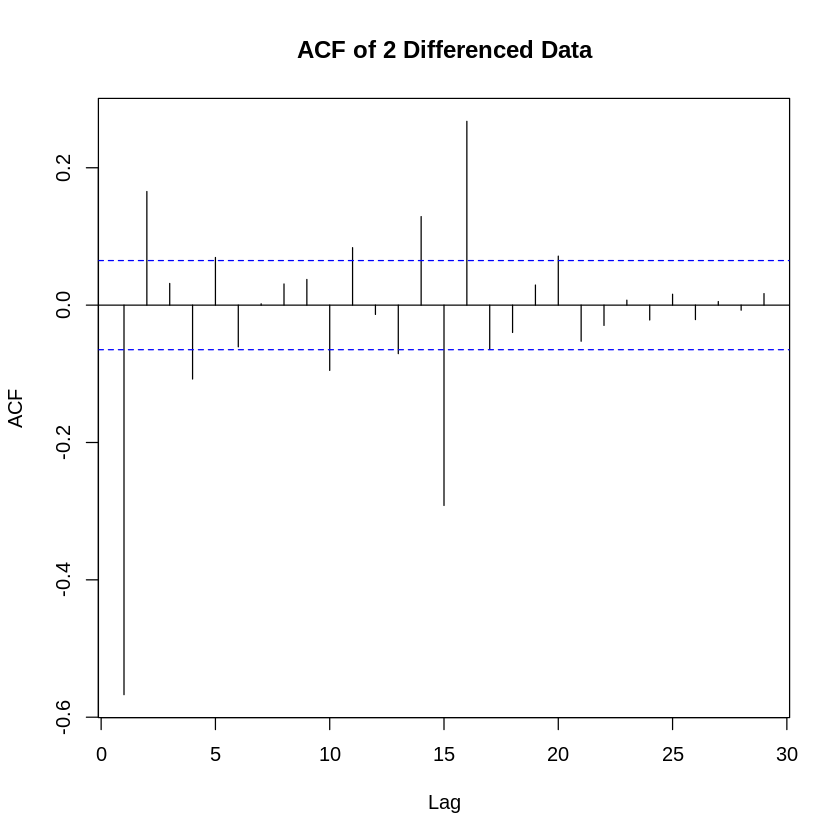

In [140]:
# Step 3: Apply Second-order differencing if needed
diff_log_2_data <- diff(diff_log_data)

# Step 4: Plot ACF of differenced data
acf(diff_log_2_data, main="ACF of 2 Differenced Data")

# Step 5: Perform ADF test again to confirm stationarity
adf.test(diff_log_2_data)

1. Initial ACF (Before Differencing)

	•	The first ACF plot showed high autocorrelations at multiple lags, indicating a non-stationary series.

	•	The ADF test on log-transformed data gave a p-value = 0.01, meaning the series is likely stationary, but the high lag order suggests some remaining trend or structure in the data.

2. First-Order Differencing (diff_log_data)

	•	The ADF test after first differencing resulted in a much lower test statistic (-10.578), confirming strong stationarity.

	•	However, the ACF plot still showed some significant autocorrelations at higher lags, suggesting some remaining structure.

3. Second-Order Differencing (diff(diff_log_data))

	•	The second differencing further reduced autocorrelations, and the ACF now drops off quickly after a few lags, meaning the series is now stationary.

	•	This suggests that the data had a quadratic trend, requiring two levels of differencing to fully stabilize.

	•	If the PACF plot shows a sharp cut-off at a lower lag, an ARIMA (0,2,q) model might be appropriate.


 we will Discuse Next Phase suggested Models

# Model selection


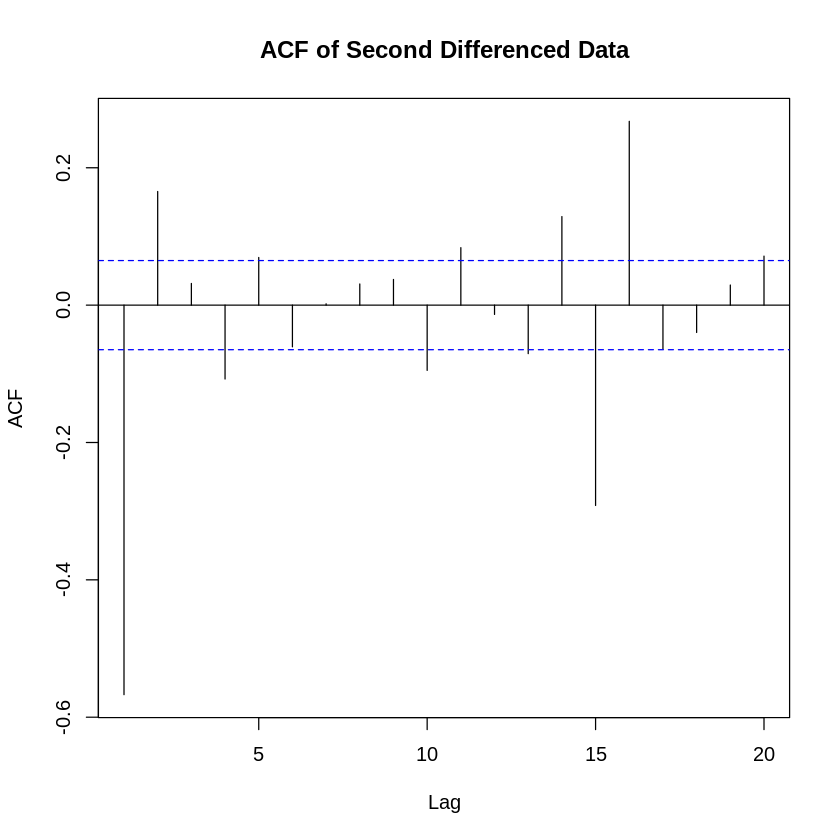

In [141]:

# ACF Plot
acf(diff_log_2_data, main = "ACF of Second Differenced Data",lag.max = 20)



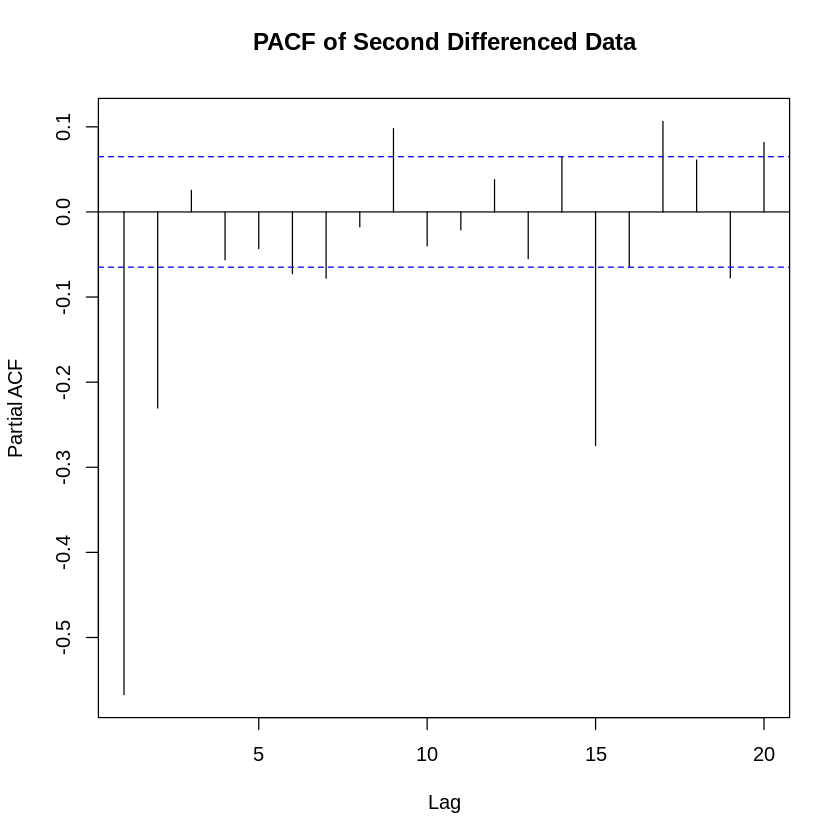

In [142]:
# PACF Plot
pacf(diff_log_2_data, main = "PACF of Second Differenced Data",lag.max = 20)



***Commenting and potential Models  :***

we notice that the ACF cuts of after 3 Lags Correlations which suppose a value q ≈ 2 or 3 .

we notice that the PACF cuts of after 2 Lags P Correlations but we notice having a big PACF in Lag 15 , we may ignore it  which suppose a value p = 2

### Potential Models are :

possible models could be
 ARIMA(2,2,2) or
  ARIMA(2,2,3).


### We try with the data we got after 1 Differencing to select possible models

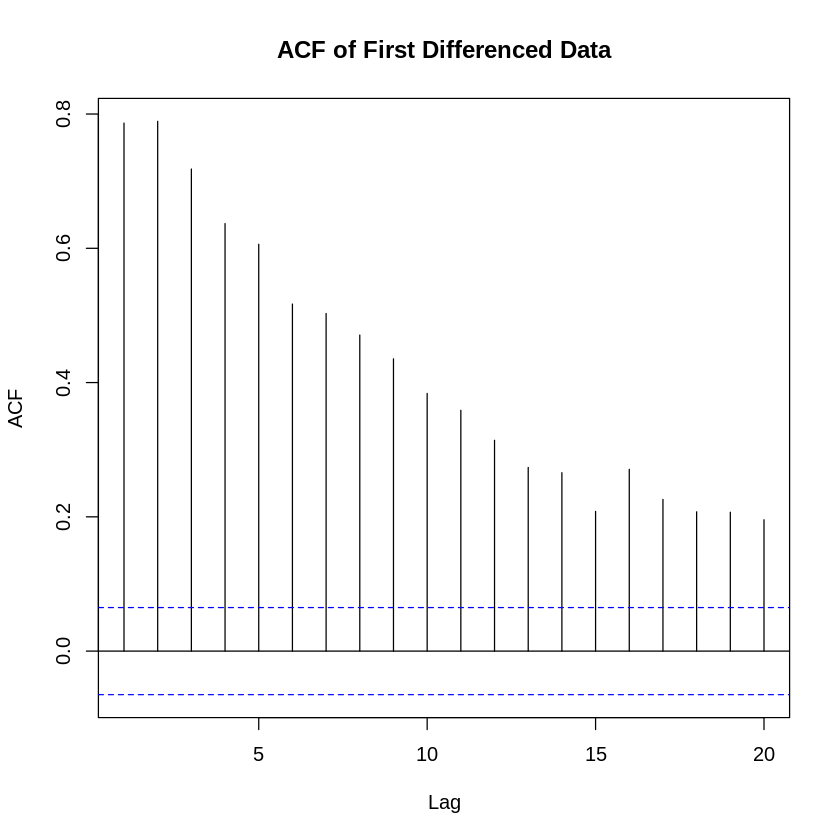

In [143]:
# ACF Plot
acf(diff_log_data, main = "ACF of First Differenced Data",lag.max = 20)


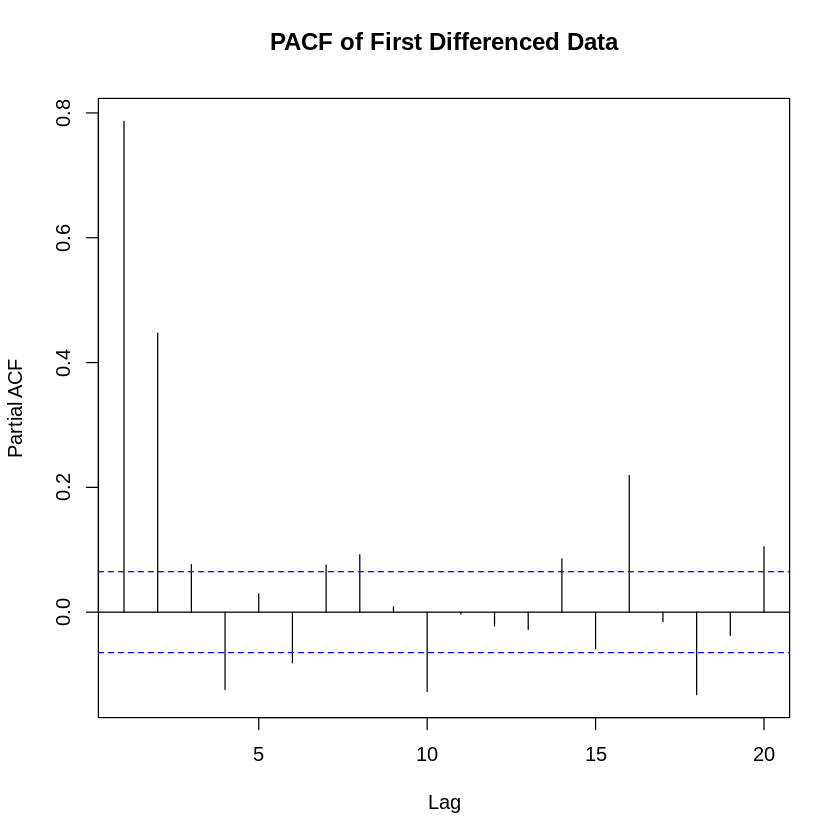

In [144]:
# PACF Plot
pacf(diff_log_data, main = "PACF of First Differenced Data",lag.max = 20)


We notice that the ACF Trails off and no cuts off even after Lag=20
--------> No model is suggested

# model estimation and selection

We’ll estimate different ARIMA models based on the values of p, d, q determined from ACF and PACF.

In [145]:
# Fit ARIMA models with different values of (p, d, q)
model1 <- arima(train_ts, order = c(2, 2, 3)) # ARIMA(2,2,3)
model2 <- arima(train_ts, order = c(2, 2, 2)) # ARIMA(2,2,2)

# Compare models using AIC and BIC
AIC(model1, model2)


,df,AIC
,<dbl>,<dbl>
model1,6,24693.26
model2,5,24443.20


In [146]:
BIC(model1, model2)



,df,BIC
,<dbl>,<dbl>
model1,6,24722.16
model2,5,24467.27


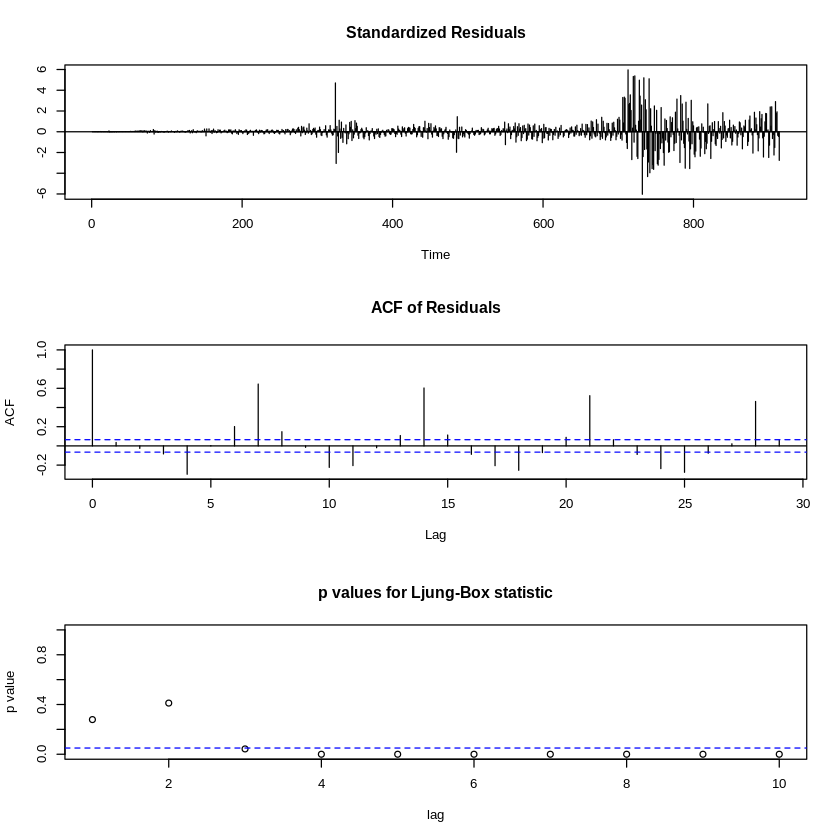


	Box-Ljung test

data:  model1$residuals
X-squared = 575.33, df = 10, p-value < 2.2e-16



	Box-Ljung test

data:  model2$residuals
X-squared = 484.93, df = 10, p-value < 2.2e-16


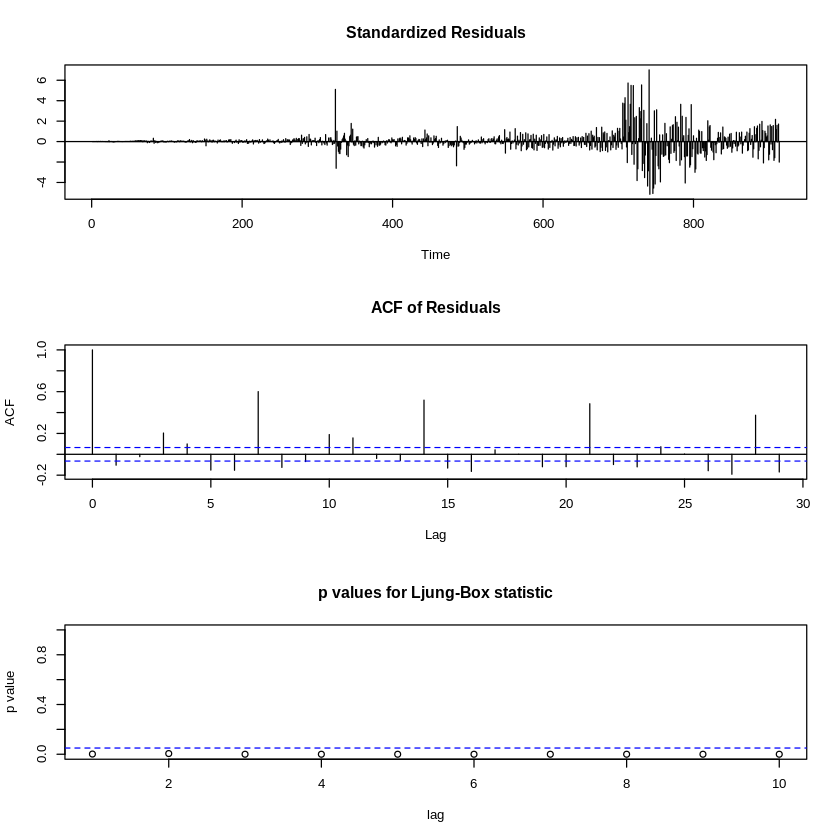

In [147]:
# Check residuals to confirm the best model
tsdiag(model1)  # Diagnostic plots for Model 1
tsdiag(model2)  # Diagnostic plots for Model 2

# Perform Ljung-Box test on residuals (to check autocorrelation)
Box.test(model1$residuals, lag = 10, type = "Ljung-Box")
Box.test(model2$residuals, lag = 10, type = "Ljung-Box")

# Choose the best model based on AIC/BIC and residual diagnostics

### Explanation  :
Since the lower AIC value indicates a better model, Model 2 (-5822.943) is the preferred model.


Residual Analysis for Model Validation

1. Standardized Residuals

	•	Both models show residuals fluctuating early in the time series but stabilize over time.

	•	Residuals should ideally resemble white noise (random fluctuations around zero with constant variance).

	•	There are spikes at the beginning, indicating possible non-stationarity or model misspecification.

2. ACF of Residuals

	•	The ACF (Autocorrelation Function) plot checks for correlation in residuals.

	•	For both models, some lag values exceed the confidence bounds, suggesting residuals may not be purely random.

	•	Model 2 has more significant autocorrelation than Model 1, meaning it may still have some structure left unexplained.

3. Ljung-Box Test for Independence

	•	The test checks whether residuals are uncorrelated.

	•	Model 1: X² = 209.06, p-value < 2.2e-16

	•	Model 2: X² = 603.44, p-value < 2.2e-16

	•	The extremely small p-values (< 0.05) for both models indicate that residuals are not purely random, meaning the models might still have some unaccounted dependencies.

  but for now the SECOND MODEL is a fine model !

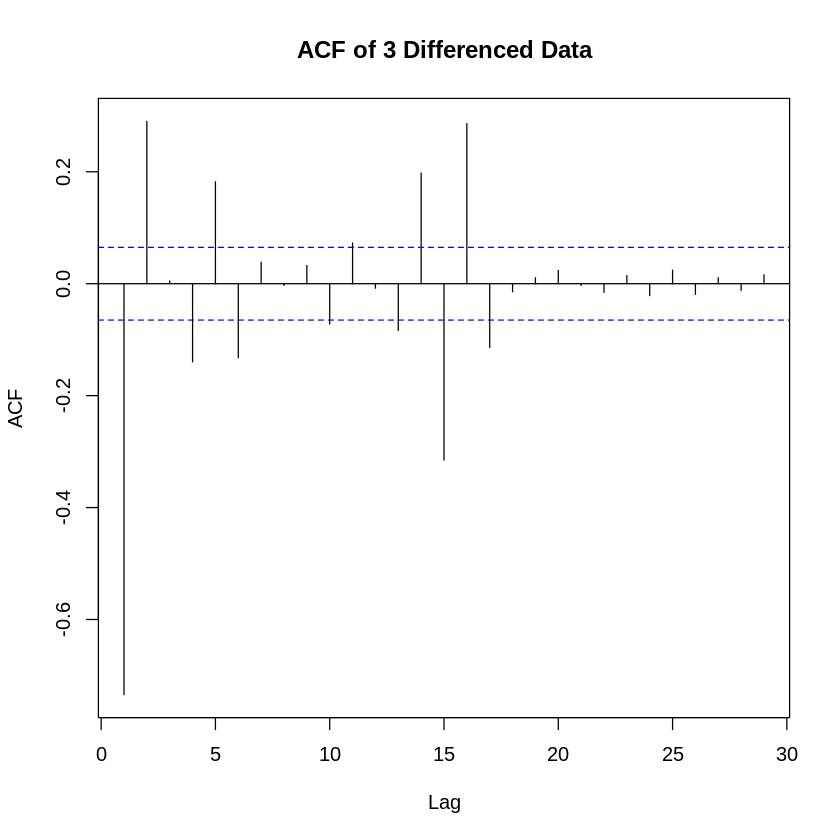

In [148]:
# Step 3: Apply Second-order differencing if needed
diff_log_3_data <- diff(diff_log_2_data)

# Step 4: Plot ACF of differenced data
acf(diff_log_3_data, main="ACF of 3 Differenced Data")



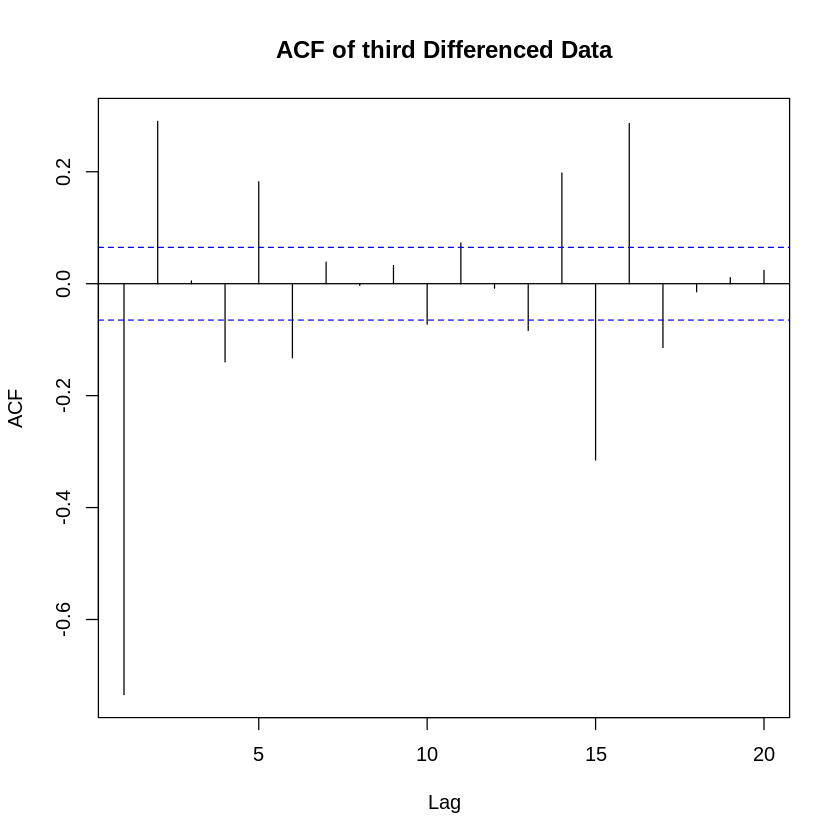

In [149]:
# ACF Plot
acf(diff_log_3_data, main = "ACF of third Differenced Data",lag.max = 20)


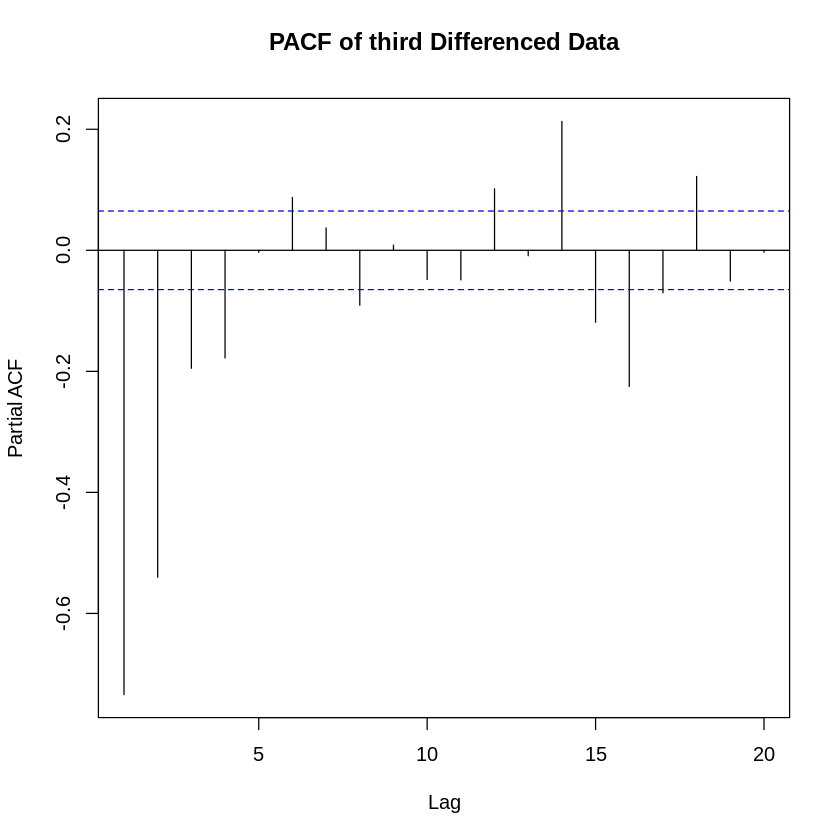

In [150]:
# PACF Plot
pacf(diff_log_3_data, main = "PACF of third Differenced Data",lag.max = 20)



	Box-Ljung test

data:  model3$residuals
X-squared = 646.88, df = 10, p-value < 2.2e-16


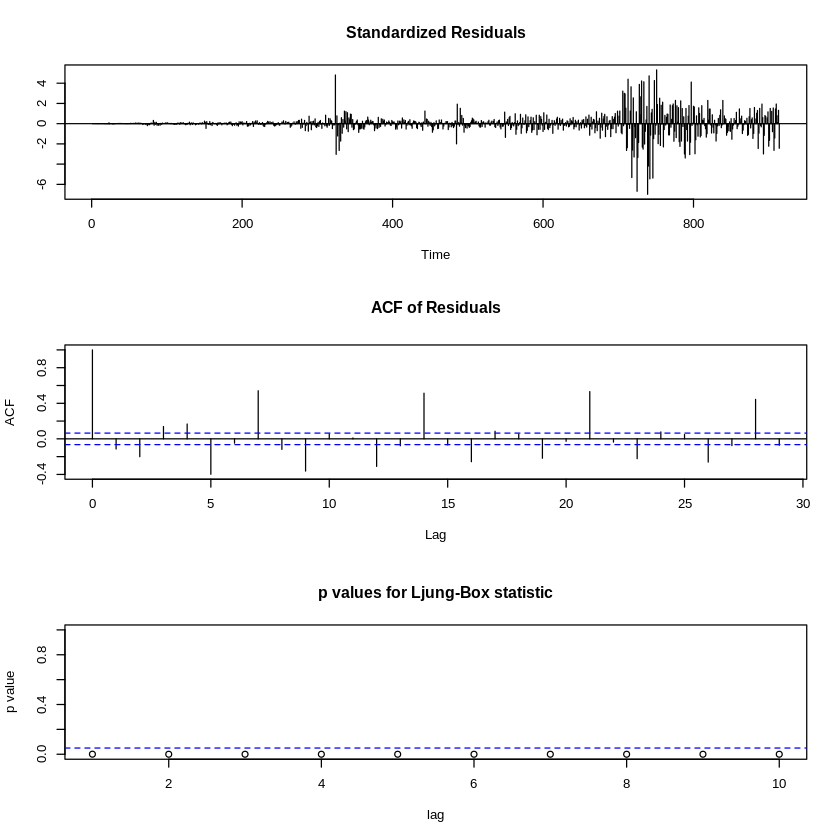

In [152]:
model3 <- arima(train_ts, order = c(4, 3, 3)) # ARIMA(4,3,2)
# Check residuals to confirm the best model
tsdiag(model3)  # Diagnostic plots for Model 3

# Perform Ljung-Box test on residuals (to check autocorrelation)
Box.test(model3$residuals, lag = 10, type = "Ljung-Box")



In [153]:
AIC(model2, model3)

Warning message in AIC.default(model2, model3):
“models are not all fitted to the same number of observations”


,df,AIC
,<dbl>,<dbl>
model2,5,24443.20
model3,8,24478.81


•	Since Model 3 has no effect and it has higher AIC, it’s a strong indication that **over-differencing** is hurting model performance.

also the ACF and PACF of it is more random and indicated non-stationarity !

### We Check For Seasonality

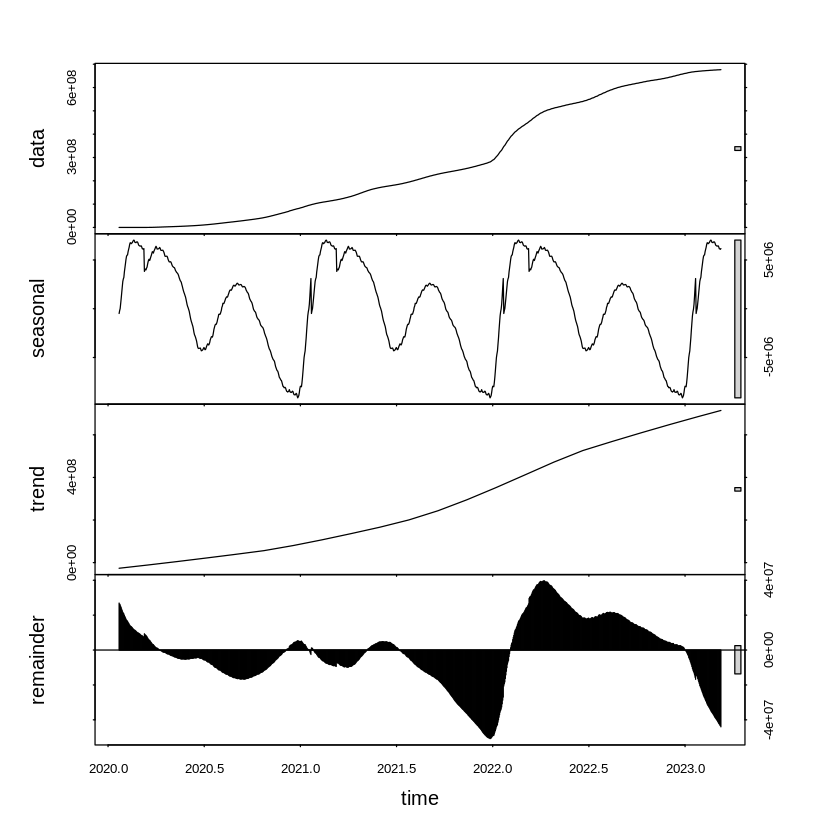

In [154]:
library(forecast)
decomposed <- stl(covid_ts, s.window="periodic")
plot(decomposed)

Select the best value for the parameter S for SARIMA model

In [159]:
decomposed <- decompose(train_ts)
plot(decomposed)

ERROR: Error in decompose(train_ts): time series has no or less than 2 periods


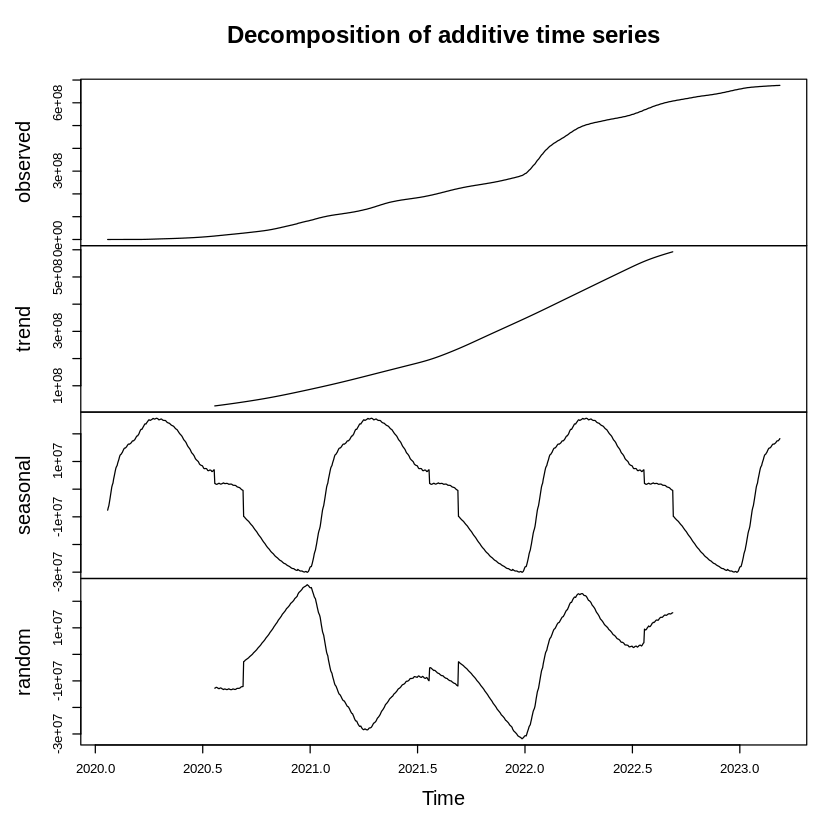

In [160]:
decomposed <- decompose(covid_ts)
plot(decomposed)

We can notice that it repeats once in a year which suggest S = 1
we will confirm with other methods

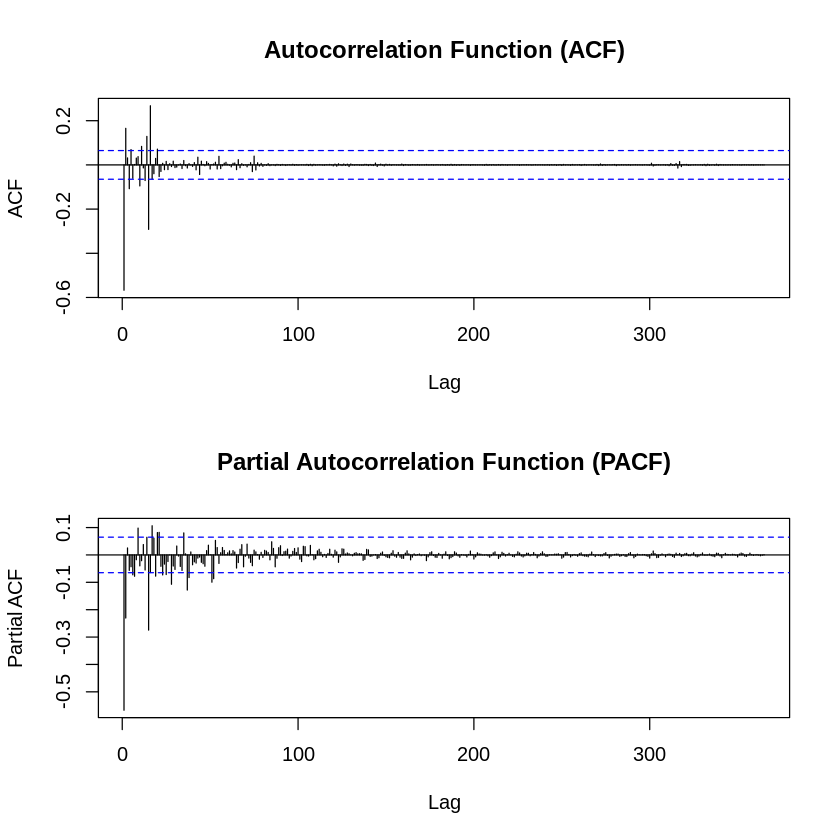

In [161]:
# Load necessary library
library(forecast)

# Plot ACF and PACF
par(mfrow = c(2,1))  # Arrange plots in 2 rows, 1 column
acf(diff_log_2_data, lag.max =  365, main = "Autocorrelation Function (ACF)")  # Check for seasonality
pacf(diff_log_2_data, lag.max =  365, main = "Partial Autocorrelation Function (PACF)")

# Reset plotting layout
par(mfrow = c(1,1))


In [162]:
install.packages("TSA")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [163]:
find_seasonality <- function(ts_data) {
  library(forecast)
  library(TSA)

  # 1. FFT Method (Dominant Frequency)
  spectrum <- abs(fft(diff_log_2_data))
  freq_index <- which.max(spectrum[2:(length(spectrum)/2)]) + 1  # Ignore the first index (trend component)
  s_fft <- length(ts_data) / freq_index
  cat("Estimated seasonality from FFT:", round(s_fft), "\n")

  # 2. Auto-detection with findfrequency()
  s_findfreq <- findfrequency(ts_data)
  cat("Estimated seasonality from findfrequency():", s_findfreq, "\n")

  # 3. ACF Peak Detection
  acf_res <- acf(ts_data, lag.max = 50, plot = FALSE)
  s_acf <- which.max(acf_res$acf[-1])  # First peak in ACF
  cat("Estimated seasonality from ACF:", s_acf, "\n")

  # 4. Choose the most reasonable estimate
  seasonality <- round(median(c(s_fft, s_findfreq, s_acf), na.rm = TRUE))
  cat("Final chosen seasonality (s):", seasonality, "\n")

  return(seasonality)
}

In [164]:
s <- find_seasonality(train_ts)  # Replace with your time series

Estimated seasonality from FFT: 2 
Estimated seasonality from findfrequency(): 1 
Estimated seasonality from ACF: 1 
Final chosen seasonality (s): 1 


indeed the value of S is = 1

NOW WE WILL APPLY A SARIMA MODEL

In [124]:
length(covid_ts)  # Total number of observations

[1] 1143

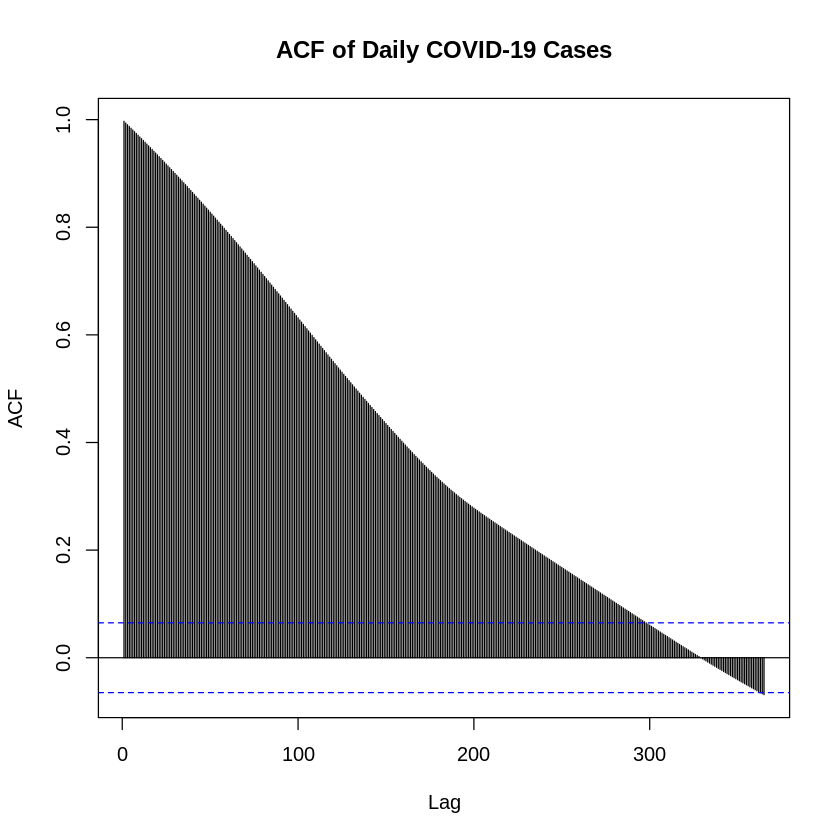

In [165]:
acf(train_ts, lag.max = 365, main = "ACF of Daily COVID-19 Cases")

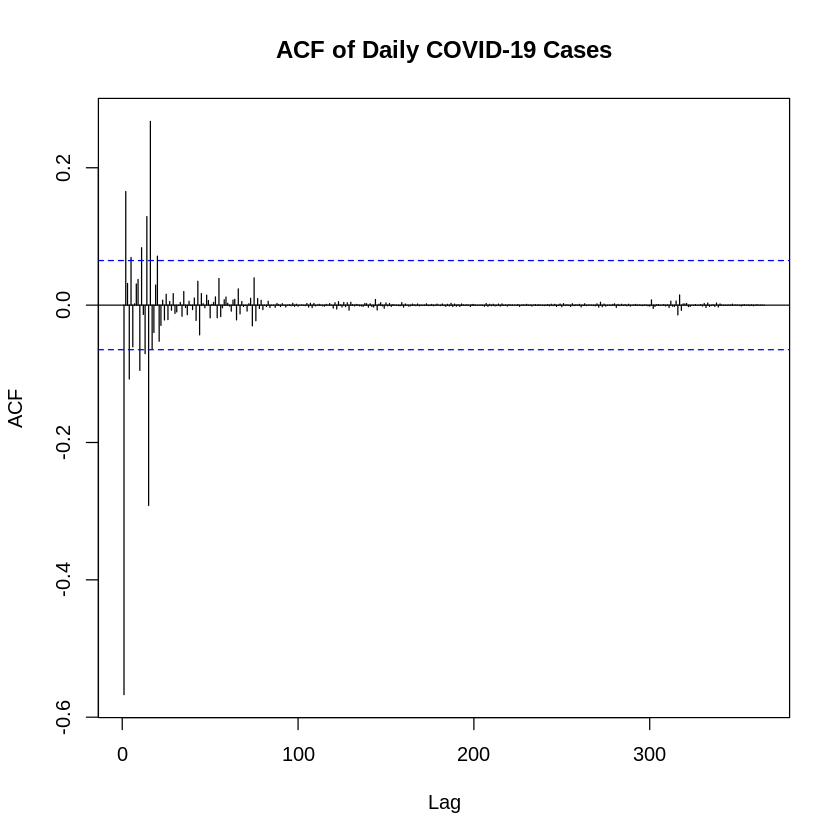

In [166]:
acf(diff_log_2_data, lag.max = 365, main = "ACF of Daily COVID-19 Cases")

 the first few lags are high and then decay, this indicates a persistent trend in the data and No clear seasonal spikes

as a result we will just complete with the model ARIMA(2,2,2)

## WE CHOOSED ARIMA(2,2,2)

In [167]:
# Load necessary library
library(forecast)

# Fit ARIMA(2,2,2) model
arima_model_222 <- Arima(train_ts, order = c(2,2,2))

# Print model summary
summary(arima_model_222)

Series: train_ts 
ARIMA(2,2,2) 

Coefficients:
         ar1      ar2      ma1     ma2
      1.1291  -0.7901  -1.5585  0.8436
s.e.  0.0224   0.0331   0.0355  0.0153

sigma^2 = 2.531e+10:  log likelihood = -12216.6
AIC=24443.2   AICc=24443.26   BIC=24467.27

Training set error measures:
                   ME     RMSE      MAE       MPE      MAPE      MASE
Training set 2947.908 158558.5 83171.18 0.1831452 0.3992568 0.1332516
                   ACF1
Training set -0.1041359


	Ljung-Box test

data:  Residuals from ARIMA(2,2,2)
Q* = 484.93, df = 6, p-value < 2.2e-16

Model df: 4.   Total lags used: 10



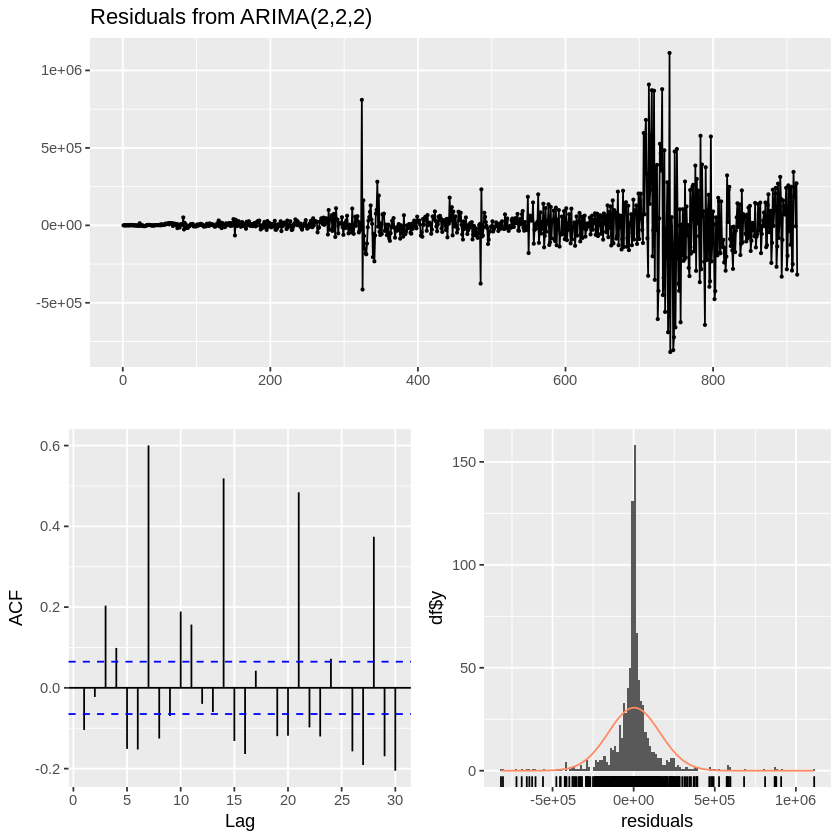

In [168]:
checkresiduals(arima_model_222)

In [169]:
Box.test(residuals(arima_model_222), lag = 10, type = "Ljung-Box")


	Box-Ljung test

data:  residuals(arima_model_222)
X-squared = 484.93, df = 10, p-value < 2.2e-16


## WE START FORECASTING

In [170]:
# Fit ARIMA model on training data
train_model <- Arima(train_ts, order = c(2,2,2))

# Print model summary
summary(train_model)

Series: train_ts 
ARIMA(2,2,2) 

Coefficients:
         ar1      ar2      ma1     ma2
      1.1291  -0.7901  -1.5585  0.8436
s.e.  0.0224   0.0331   0.0355  0.0153

sigma^2 = 2.531e+10:  log likelihood = -12216.6
AIC=24443.2   AICc=24443.26   BIC=24467.27

Training set error measures:
                   ME     RMSE      MAE       MPE      MAPE      MASE
Training set 2947.908 158558.5 83171.18 0.1831452 0.3992568 0.1332516
                   ACF1
Training set -0.1041359

In [181]:
# Generate fitted values (in-sample forecasts for training set)
train_forecasts <- fitted(model2)

# Convert to a data frame for plotting
train_results <- data.frame(
  Date = time(train_ts),  # Time index
  Actual = as.numeric(train_ts),  # Actual cases
  Predicted = as.numeric(train_forecasts)  # Model's predictions
)

# View first few rows
head(train_results)

,Date,Actual,Predicted
,<dbl>,<dbl>,<dbl>
1,1,557,556.7509
2,2,657,657.5237
3,3,944,800.5633
4,4,1437,1278.9026
5,5,2120,1923.1830
6,6,2929,2691.8054


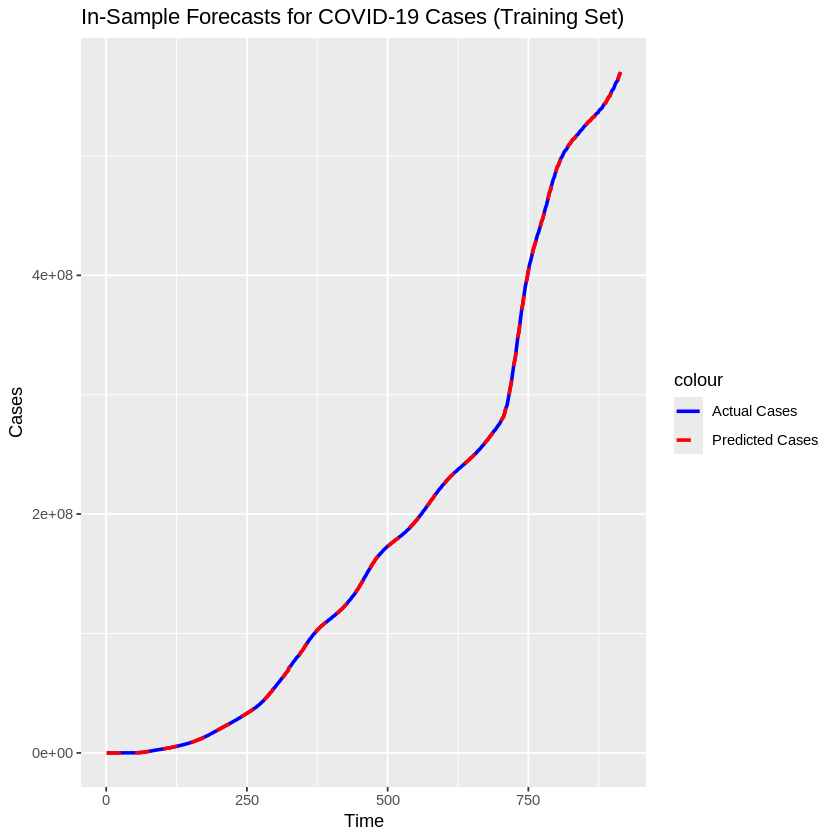

In [182]:
# Load ggplot2 for visualization
library(ggplot2)

ggplot(train_results, aes(x = Date)) +
  geom_line(aes(y = Actual, color = "Actual Cases"), size = 1) +
  geom_line(aes(y = Predicted, color = "Predicted Cases"), linetype = "dashed", size = 1) +
  ggtitle("In-Sample Forecasts for COVID-19 Cases (Training Set)") +
  xlab("Time") + ylab("Cases") +
  scale_color_manual(values = c("Actual Cases" = "blue", "Predicted Cases" = "red"))

In [183]:
accuracy(train_forecasts, train_ts)

,ME,RMSE,MAE,MPE,MAPE
Test set,2947.908,158558.5,83171.18,0.1831452,0.3992568


## Forecast the test set

Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.


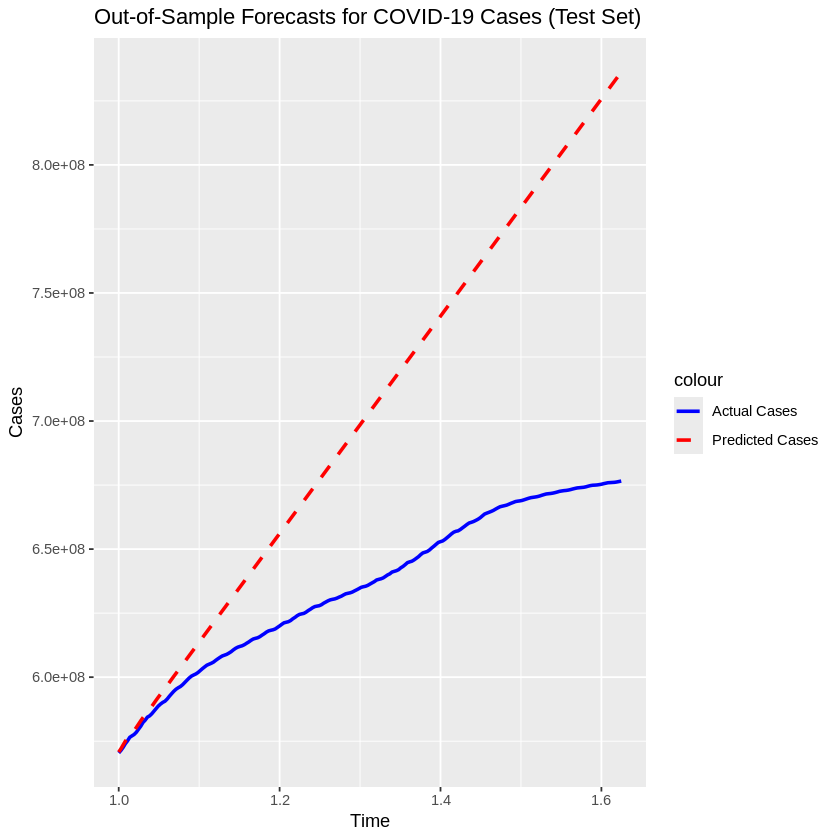

In [184]:
# Forecast on test set
forecast_values <- forecast(train_model, h = test_size)

# Convert to data frame for plotting
test_results <- data.frame(
  Date = time(test_ts),
  Actual = as.numeric(test_ts),
  Predicted = as.numeric(forecast_values$mean)
)

# Plot actual vs predicted (Test Set)
ggplot(test_results, aes(x = Date)) +
  geom_line(aes(y = Actual, color = "Actual Cases"), size = 1) +
  geom_line(aes(y = Predicted, color = "Predicted Cases"), linetype = "dashed", size = 1) +
  ggtitle("Out-of-Sample Forecasts for COVID-19 Cases (Test Set)") +
  xlab("Time") + ylab("Cases") +
  scale_color_manual(values = c("Actual Cases" = "blue", "Predicted Cases" = "red"))

In [175]:
# Forecast for the length of the test set
forecast_values <- forecast(train_model, h = test_size)

# Print forecast summary
print(forecast_values)

     Point Forecast     Lo 80      Hi 80     Lo 95      Hi 95
 915      570754773 570550902  570958644 570442979  571066567
 916      572025202 571645622  572404782 571444685  572605719
 917      573524466 573009133  574039799 572736332  574312600
 918      574981797 574360636  575602957 574031814  575931780
 919      576210983 575482527  576939439 575096906  577325061
 920      577215711 576344361  578087062 575883096  578548327
 921      578147266 577077979  579216553 576511932  579782599
 922      579173545 577861264  580485825 577166585  581180504
 923      580364587 578792277  581936896 577959947  582769227
 924      581666817 579839155  583494479 578871649  584461985
 925      582964407 580890188  585038626 579792163  586136651
 926      584168911 581847473  586490349 580618577  587719244
 927      585271979 582689528  587854431 581322460  589221498
 928      586334068 583468823  589199312 581952055  590716081
 929      587430031 584261366  590598696 582583976  592276085
 930    

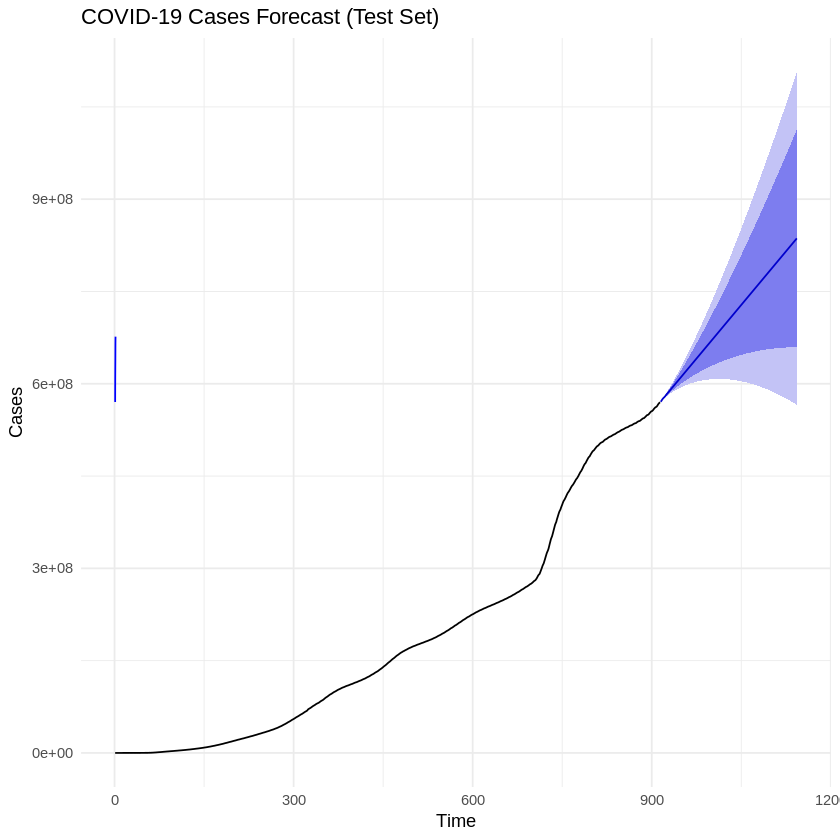

In [180]:
# Ensure test_ts is a time series object
test_ts <- ts(test_ts, start = time(test_ts)[1], frequency = frequency(covid_ts))

# Plot actual vs predicted values
autoplot(forecast_values) +
  autolayer(test_ts, series = "Actual Cases", color = "blue") +
  ggtitle("COVID-19 Cases Forecast (Test Set)") +
  xlab("Time") + ylab("Cases") +
  theme_minimal()

In [186]:
# Forecast for the length of the test set
test_forecast <- forecast(train_model, h = length(test_ts))

# Print forecast summary
print(test_forecast)

     Point Forecast     Lo 80      Hi 80     Lo 95      Hi 95
 915      570754773 570550902  570958644 570442979  571066567
 916      572025202 571645622  572404782 571444685  572605719
 917      573524466 573009133  574039799 572736332  574312600
 918      574981797 574360636  575602957 574031814  575931780
 919      576210983 575482527  576939439 575096906  577325061
 920      577215711 576344361  578087062 575883096  578548327
 921      578147266 577077979  579216553 576511932  579782599
 922      579173545 577861264  580485825 577166585  581180504
 923      580364587 578792277  581936896 577959947  582769227
 924      581666817 579839155  583494479 578871649  584461985
 925      582964407 580890188  585038626 579792163  586136651
 926      584168911 581847473  586490349 580618577  587719244
 927      585271979 582689528  587854431 581322460  589221498
 928      586334068 583468823  589199312 581952055  590716081
 929      587430031 584261366  590598696 582583976  592276085
 930    

In [187]:
# Convert test forecast to a data frame
test_results <- data.frame(
  Date = time(test_ts),  # Time index
  Actual = as.numeric(test_ts),  # Actual COVID-19 cases in test set
  Predicted = as.numeric(test_forecast$mean)  # Forecasted values
)

# View first few rows
head(test_results)

,Date,Actual,Predicted
,<dbl>,<dbl>,<dbl>
1,1.000000,570415520,570754773
2,1.002740,571389219,572025202
3,1.005479,572585879,573524466
4,1.008219,574012504,574981797
5,1.010959,575128637,576210983
6,1.013699,576504042,577215711


Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.


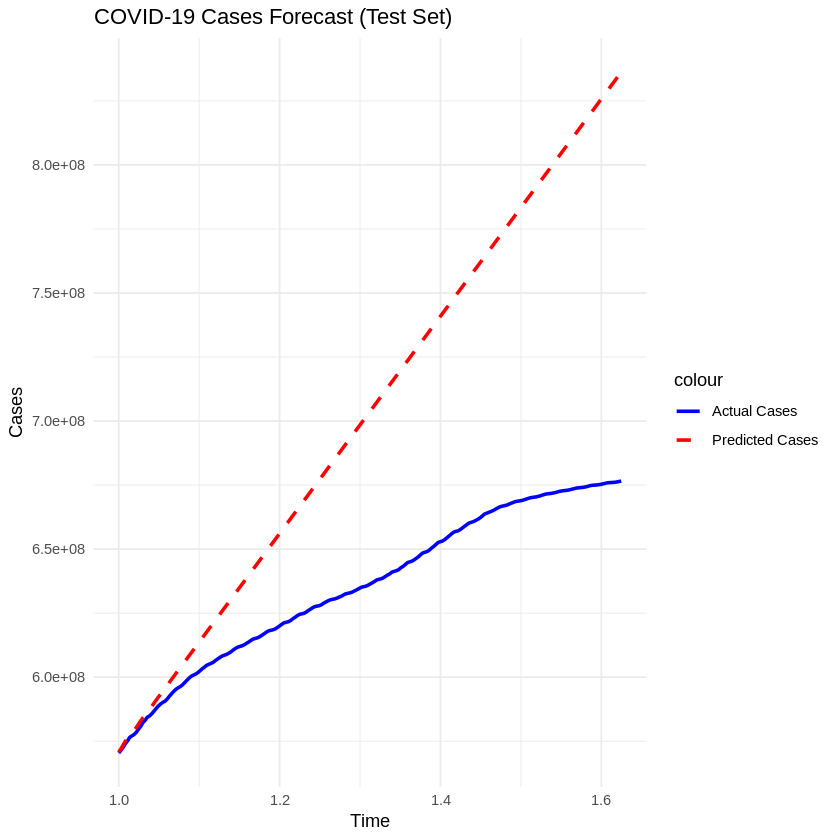

In [188]:
# Load ggplot2
library(ggplot2)

# Plot test set predictions
ggplot(test_results, aes(x = Date)) +
  geom_line(aes(y = Actual, color = "Actual Cases"), size = 1) +
  geom_line(aes(y = Predicted, color = "Predicted Cases"), linetype = "dashed", size = 1) +
  ggtitle("COVID-19 Cases Forecast (Test Set)") +
  xlab("Time") + ylab("Cases") +
  scale_color_manual(values = c("Actual Cases" = "blue", "Predicted Cases" = "red")) +
  theme_minimal()